# Twitter US Airline Sentiment with Keras

## 1. Domain introduction
[Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment) is a popular NLP dataset on Kaggle. It contains Twitter reviews of the US airlines. Each one has a sentiment attached to it - positive, neutral or negative. 

In this article, I will present my approach to guessing the sentiment of a particular opinion.

## 2. Data description and visualization

First, let's check first few rows of the raw data: 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


My goal is to determine sentiment based only on the Tweet itself, so I will remove additional columns, expand the columns width and show more rows:

In [2]:
pd.set_option("display.max_colwidth", 200)
simple_df = df.loc[:, ["text", "airline_sentiment"]]
simple_df.head(15)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


Few informations about opinions length and sentiment:

Mean single Twitt's lengh: 103.82 characters


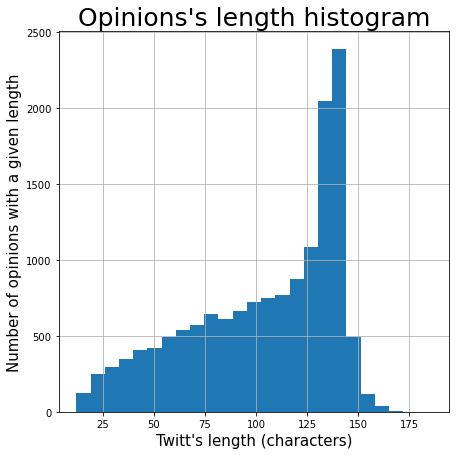

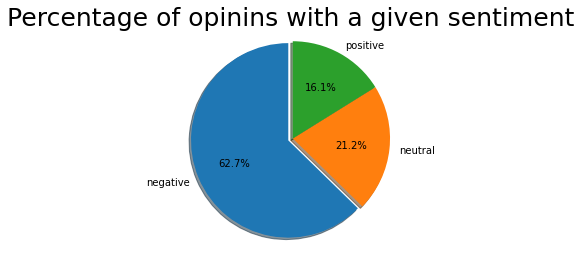

In [3]:
import matplotlib.pyplot as plt

print("Mean single Twitt's lengh: %.2f characters" % df["text"].str.len().mean())
df["text"].str.len().hist(figsize=(7, 7), bins=25)
plt.xlabel("Twitt's length (characters)", fontsize=15)
plt.ylabel("Number of opinions with a given length", fontsize=15)
plt.title("Opinions's length histogram", fontsize=25)
plt.show()

labels = ['negative', 'neutral', 'positive']
negative = df[df.airline_sentiment == 'negative'].size
neutral = df[df.airline_sentiment == 'neutral'].size
positive = df[df.airline_sentiment == 'positive'].size
explode = [0.05, 0.0, 0.0]
sizes = [negative, neutral, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of opinins with a given sentiment", fontsize=25)
plt.show()

## 3. Baseline model

I usually start with a fairly simple model to know how my actions affect the outcome.

### 3.1 Label encoding
First we have to encode the labels into a form that the algorithm understands - numbers:

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(simple_df["airline_sentiment"])
simple_df.loc[:,"sentiment_encoded"] = le.transform(simple_df["airline_sentiment"])

labels = simple_df["airline_sentiment"].unique()
labels_encoded = le.transform(labels)

for idx in range(len(labels)):
    print("Number for " + labels[idx] + " sentiment: " + str(labels_encoded[idx]))

simple_df.head()

Number for neutral sentiment: 1
Number for positive sentiment: 2
Number for negative sentiment: 0


,text,airline_sentiment,sentiment_encoded
0,@VirginAmerica What @dhepburn said.,neutral,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,2
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,0
4,@VirginAmerica and it's a really big bad thing about it,negative,0


### 3.2 Split train and test data
Second - I will choose some special test data to check model performance. The network will train **only** on 90% of data and next we'll check with some metrics how it perform on the remaining 10%. Pay attention to the "stratify" parameter - it ensures that all the sentiment types will be in the same proportion.

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

def split_to_tensors(column_name):
    X_train, X_test, y_train, y_test = train_test_split(
        simple_df[column_name], simple_df['sentiment_encoded'], test_size=0.1, random_state=42, stratify=simple_df['sentiment_encoded'])
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    return train_ds, test_ds

### 3.3 Changing the collection type, splitting into batches

TensorFlow has an internal type for datasets - tf.data.Dataset. Just as [documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) mentions - "Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.". Next - I'll combine consecutive consecutive elements into batches of the size I'll specify. TensorFlow will feed neural network in this number of rows at a time. This topic is a bit complicated for this article - you can find more information [here ("What is a batch?")](https://stackoverflow.com/a/41176694) and [here (tips for batch size)](https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu/236393#236393).

In [6]:
import tensorflow as tf
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

train_ds, test_ds = split_to_tensors("text")

BATCH_SIZE = 128

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

print(f"Number of batches in train_ds: {train_ds.cardinality()}")
print(f"Number of batches in test_ds: {test_ds.cardinality()}")

Number of batches in train_ds: 103
Number of batches in test_ds: 12


### 3.4 Encoding Twitts

In one of the previous parts I changed labels to a version that the algorithm understands. Now we need to do something similar with Twitts. There are some more sophisticated tools, but for now I will choose the standard one - TextVectorization. I encourage you to check out more informations about this processing: [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [7]:
from tensorflow.keras.layers import TextVectorization
import string
import re

def get_adapted_vectorizer(train_ds, max_features=20000, embedding_dim=128, sequence_length=500, standardize="lower_and_strip_punctuation"):
    vectorize_layer = TextVectorization(
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
        standardize=standardize
    )
    
    text_ds = train_ds.map(lambda x, y: x)

    #Train Vectorizer
    vectorize_layer.adapt(text_ds)
    return vectorize_layer


vectorize_layer = get_adapted_vectorizer(train_ds, standardize=None)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
vectorized_train_ds = train_ds.map(vectorize_text)
vectorized_test_ds = test_ds.map(vectorize_text)

TensorFlow allows us to do a few tricks for [better performance](https://www.tensorflow.org/guide/data_performance).

With "prefetch" method input pipeline [is reading data for next step](https://www.tensorflow.org/guide/data_performance#prefetching) during the current one.

The "cache" method [can cache a dataset](https://www.tensorflow.org/guide/data_performance#caching) in memory or on local storage - so some operations (for example - opening and data reading) will not be performed at each epoch.

In [8]:
vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

### 3.5 A brief note on used metrics

This problem is an example of "imbalanced dataset". It means that one of class ("negative" in this article) has significantly more rows than others. You can get 62.7% acurracy... just by assigning the same prediction to all examples. There are more reliable metrics for imbalanced dataset - one of them is [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Unfortunately this dataset is not strongly imbalanced and metric ROC_AUC is little cumbersome for multiclass classification. It will be my main metric, but for deeper understaing model will print also standard accuracy (percentage of correct predictions).

### 3.6 Defining the network

In this paper, CNN will be used only for the baseline model, so I will not describe it too much. At this point, the relevant information is that convolution layers are popular for deep learning, but they are not specialized for sequential data (as full sentences/posts or time series data).

TODO: add more informations

In [9]:
from tensorflow.keras import layers
import keras
from keras import callbacks

# This layer takes all encoded Twitts
inputs = tf.keras.Input(shape=(None,), dtype="int64")

max_features = 20000
embedding_dim = 128
x = layers.Embedding(max_features, embedding_dim)(inputs)

# Two convolution layers
x = layers.Conv1D(64, 7)(x)
x = layers.GlobalMaxPooling1D()(x)

# softmax activation function allows to make multiclass predictions
predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

I will use [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) - it stops training under defined circumstances. In my case - 5 epochs without val_auc improvement. Epoch is ["one pass over the entire dataset"](https://keras.io/getting_started/faq/#what-do-sample-batch-and-epoch-mean). In these networks, that's enough.

I still need to determine the maximum number of epochs. My tests showed that - for now - 20 is sufficient.

In [10]:
def print_results(hist, accuracy_curve=False):
    print("Highest val_auc: ", str(max(hist.history['val_auc'])))
    print("Highest val_accuracy: ", str(max(hist.history['val_accuracy'])))
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.plot(history.history['auc'], label='train')
    plt.plot(history.history['val_auc'], label='test')
    plt.legend()
    plt.show()
    if accuracy_curve==True:
        plt.title('Learning Curves')
        plt.xlabel('Epoch')
        plt.ylabel('accuracy')
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='test')
        plt.legend()
        plt.show()

Highest val_auc:  0.9304133653640747
Highest val_accuracy:  0.7964481115341187


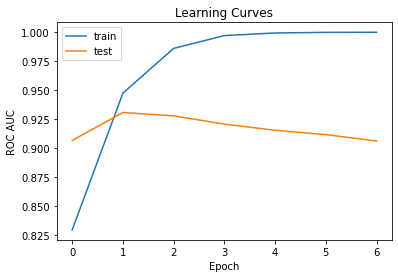

In [11]:
epochs = 20

earlystopping5 = callbacks.EarlyStopping(monitor="val_auc",
                                        mode="max", patience=5,
                                        restore_best_weights=True)

history = model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping5], batch_size=BATCH_SIZE, verbose=0)
print_results(history)

The result is better than random values or setting all predictions as "negative", but it's possible to obtain model with higher performance.

## 4. LSTM model

I will use [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) (Long Short-Term Memory) layers in the main model. It's a type of RNN (recurrent neural networks). RNN allows to analyze sequential and time series data. This type of network can memorize some information from previous steps - in this dataset it can use context from the beginning of Twitt during processing its end.

One of RNN's problems is vanishing gradient - [gradients used to compute the weight update may get very close to zero, preventing the network from learning new weights](https://machinelearningmastery.com/an-introduction-to-recurrent-neural-networks-and-the-math-that-powers-them/). LSTM is trying to curb this problem.

TODO: more info

In [12]:
def two_layers_lstm(max_features=20000, embedding_dim=128, lstm1_units=64, dropout1=0.0, lstm2_units=64, dropout2=0.0):
    inputs = tf.keras.Input(shape=(None,), dtype="int64")

    x = layers.Embedding(max_features, embedding_dim)(inputs)

    x = layers.Bidirectional(layers.LSTM(lstm1_units, return_sequences=True, dropout=dropout1))(x)
    x = layers.Bidirectional(layers.LSTM(lstm2_units, dropout=dropout2))(x)

    predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

    model = tf.keras.Model(inputs, predictions)
    return model

Highest val_auc:  0.9293271899223328
Highest val_accuracy:  0.8039617538452148


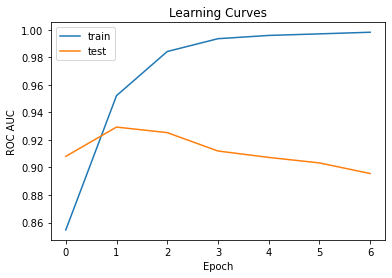

In [13]:
model = two_layers_lstm()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

history = model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping5], batch_size=BATCH_SIZE, verbose=0)
print_results(history)

For now it doesn't look like a better model, but after few tweaks I'll get much higher performance.

### 5. Lowercase and strip punctuation
Usually words and their lowercase has the same or similar meaning. Of course it's not 100% true...
1. "general" is an adjective, but "General" is a military person
2. words with all leters uppercase could have additional emotional significance

It's best to check several types of preprocessing, but in a lot of papers we can find general rule to use lowercase in small datasets and try to avoid lowercase in bigger datasets.

An analogous rule applies to punctuation. On the one hand punctuation could add some meaning, but on the other - it's better to not treat "word" and "word." as completely different units. Sometimes it can be a good idea to leave only some punctuation marks - for example exclamation points or question marks.

Highest val_auc:  0.9374014139175415
Highest val_accuracy:  0.8169398903846741


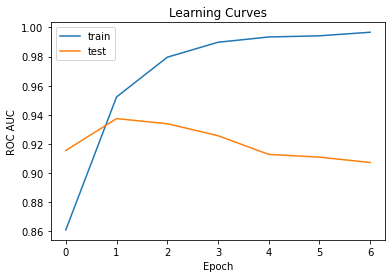

In [14]:
vectorize_layer = get_adapted_vectorizer(train_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
vectorized_train_ds = train_ds.map(vectorize_text)
vectorized_test_ds = test_ds.map(vectorize_text)

vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

from tensorflow.keras import layers
import keras

model = two_layers_lstm()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

history = model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping5], batch_size=BATCH_SIZE, verbose=0)
print_results(history)

## 6. "Stop words"

"Stop words" are words that should not affect the understanding of the sentence. There are few popular tools for removing them. For example [nltk.corpus.stopwords](https://gist.github.com/sebleier/554280) contains a list with words like "which", "it", "that". Unfortunately, the use of this tool worsened the result of my model, but i found another method. The autors of [this research](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf) proposed technique "singleton words". It involves removing words that occur only once in the entire dataset.

By the way - this research confirms my observations about arbitrary stop words lists.

Highest val_auc:  0.9381668567657471
Highest val_accuracy:  0.8094262480735779


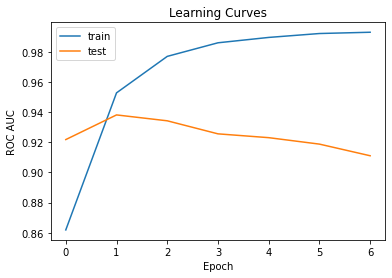

In [15]:
import nltk

def count_word_occurrences(word_nested_list):
    counts = dict()
    for word_list in word_nested_list:
        for word in word_list:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

counts = count_word_occurrences(simple_df['text'].apply(nltk.word_tokenize))

def prepare_singleton_list(counts):
    return list({ word:count for (word,count) in counts.items() if count == 1}.keys())

singletons = prepare_singleton_list(counts)
simple_df.loc[:,'stop_text'] = simple_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in singletons]))

train_ds, test_ds = split_to_tensors("stop_text")

BATCH_SIZE = 128

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

vectorize_layer = get_adapted_vectorizer(train_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
vectorized_train_ds = train_ds.map(vectorize_text)
vectorized_test_ds = test_ds.map(vectorize_text)

vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

from tensorflow.keras import layers
import keras

model = two_layers_lstm()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

history = model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping5], batch_size=BATCH_SIZE, verbose=0)
print_results(history)

# 7. Clean text
Some twitts elements have the same meaning, but a different form. For example:
- "we're" and "we are"
- "can't" and "cannot"
- "e-mail" and "email"
The model should have better performance by treating them as the same units.

Additional note: you cain improve performance of string substitution by compiling regex before the loop: [example](https://stackoverflow.com/a/33872252). I will not do that, because in dataset with this size the time saved would not be much and it would make the code less readable.

Highest val_auc:  0.9370715618133545
Highest val_accuracy:  0.812841534614563


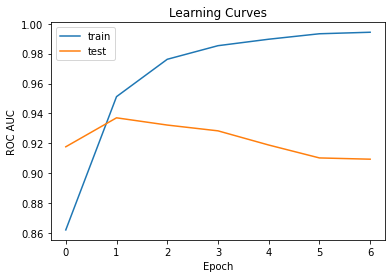

In [16]:
def clean_text(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"What's", "What is ", text)
    text = re.sub(r"\'ve", " have ", text)  # "You've" -> "You have"
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"Can't", "Cannot ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"I'm", "I am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)  # "I'll" -> 'I will'
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"hrs", "hours", text)
    return text

simple_df["text_ct"] = simple_df["text"].apply(lambda text: clean_text(text))

def count_word_occurrences(word_nested_list):
    counts = dict()
    for word_list in word_nested_list:
        for word in word_list:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

counts = count_word_occurrences(simple_df['text_ct'].apply(nltk.word_tokenize))

def prepare_singleton_list(counts):
    return list({ word:count for (word,count) in counts.items() if count == 1}.keys())

singletons = prepare_singleton_list(counts)
simple_df.loc[:,'stop_text_ct'] = simple_df['text_ct'].apply(lambda x: ' '.join([word for word in x.split() if word not in singletons]))

train_ds, test_ds = split_to_tensors("stop_text_ct")

BATCH_SIZE = 128

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

vectorize_layer = get_adapted_vectorizer(train_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
vectorized_train_ds = train_ds.map(vectorize_text)
vectorized_test_ds = test_ds.map(vectorize_text)

vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

from tensorflow.keras import layers
import keras

model = two_layers_lstm()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

history = model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping5], batch_size=BATCH_SIZE, verbose=0)
print_results(history)

Single execution is not reliable, but after more - this verision usualy gives slight improvement in accuracy and roc_auc.

## 8. Tune hyperparameters
Finally - it is difficult to select the values of some hyperparameters other than by tuning. I'll just create grid with some of them and then feed them to Optuna - framework-agnostic tuning tool.

### 8.1 Dropout
In previous models, the highest result was obtained very quickly. In the next epochs, we encountered [overfitting](https://en.wikipedia.org/wiki/Overfitting) - performance for training data was very high, but for test data it started to decrease. There are some techniques for this problem. One of them is the [dropout layer](https://keras.io/api/layers/regularization_layers/dropout/). A certain rate value should be specified. Then, with a frequency of this rate, it randomly sets layer inputs to 0 and raises the values of other inputs by 1/(1-rate). I will try to use dropout in both LSTM layers.

In [17]:
import optuna

def objective(trial):
    train_ds, test_ds = split_to_tensors("stop_text_ct")
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    BATCH_SIZE = 2 ** batch_size_power

    train_ds = train_ds.batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)

    max_features = trial.suggest_int("max_features", 10000, 30000)
    embedding_dim_power = trial.suggest_int("embedding_dim_power", 5, 7)
    embedding_dim = 2 ** embedding_dim_power
    sequence_length = trial.suggest_int("sequence_length", 250, 1000)

    vectorize_layer = get_adapted_vectorizer(train_ds, max_features=max_features, embedding_dim=embedding_dim, sequence_length=sequence_length)

    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorize_layer(text), label

    # Vectorize the data.
    vectorized_train_ds = train_ds.map(vectorize_text)
    vectorized_test_ds = test_ds.map(vectorize_text)

    vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
    vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

    from tensorflow.keras import layers
    import keras

    lstm1_units_power = trial.suggest_int("lstm1_units_power", 5, 7)
    dropout1 = trial.suggest_uniform('dropout1', 0.0, 0.6)
    lstm2_units_power = trial.suggest_int("lstm2_units_power", 5, 7)
    dropout2 = trial.suggest_uniform('dropout2', 0.0, 0.6)

    model = two_layers_lstm(max_features=max_features, embedding_dim=embedding_dim, lstm1_units=2 ** lstm1_units_power, dropout1=dropout1, lstm2_units=2 ** lstm2_units_power, dropout2=dropout2)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

    # usually this number will not be reached
    epochs = 50

    earlystopping10 = callbacks.EarlyStopping(monitor="val_auc",
                                            mode="max", patience=10,
                                            restore_best_weights=True)
    history = model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping10], batch_size=BATCH_SIZE, verbose=0)
    return max(history.history['val_auc'])

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "batch_size_power": 7,
        "max_features": 20000,
        "embedding_dim_power": 7,
        "sequence_length": 500,
        "lstm1_units_power": 6,
        "dropout1": 0.0,
        "lstm2_units_power": 6,
        "dropout2": 0.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=1) # TODO: more trials

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-10-19 13:57:42,282] A new study created in memory with name: no-name-e7b8fd3b-db73-4382-9731-bb9ee4459d36


Number of finished trials: 1
Best trial:
  ROC AUC: 0.9386690855026245
  Params: 
    batch_size_power: 7
    max_features: 20000
    embedding_dim_power: 7
    sequence_length: 500
    lstm1_units_power: 6
    dropout1: 0.0
    lstm2_units_power: 6
    dropout2: 0.0


In [18]:
def load_best_model_history(params):
    train_ds, test_ds = split_to_tensors("stop_text_ct")
    BATCH_SIZE = 2 ** params["batch_size_power"]

    train_ds = train_ds.batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)

    max_features = params["max_features"]
    embedding_dim = 2 ** params["embedding_dim_power"]
    sequence_length = params["sequence_length"]

    vectorize_layer = get_adapted_vectorizer(train_ds, max_features=max_features, embedding_dim=embedding_dim, sequence_length=sequence_length)

    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorize_layer(text), label

    # Vectorize the data.
    vectorized_train_ds = train_ds.map(vectorize_text)
    vectorized_test_ds = test_ds.map(vectorize_text)

    vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
    vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

    from tensorflow.keras import layers
    import keras

    lstm1_units_power = params["lstm1_units_power"]
    dropout1 = params['dropout1']
    lstm2_units_power = params["lstm2_units_power"]
    dropout2 = params['dropout2']

    model = two_layers_lstm(max_features=max_features, embedding_dim=embedding_dim, lstm1_units=2 ** lstm1_units_power, dropout1=dropout1, lstm2_units=2 ** lstm2_units_power, dropout2=dropout2)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

    # usually this number will not be reached
    epochs = 50

    earlystopping10 = callbacks.EarlyStopping(monitor="val_auc",
                                            mode="max", patience=10,
                                            restore_best_weights=True)
    return model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping10], batch_size=BATCH_SIZE, verbose=0)

hist = load_best_model_history(trial.params)

Finally - let's visualize best model performance 

Highest val_auc:  0.9370715618133545
Highest val_accuracy:  0.812841534614563


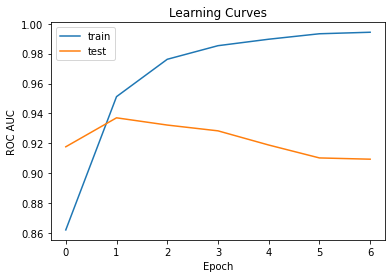

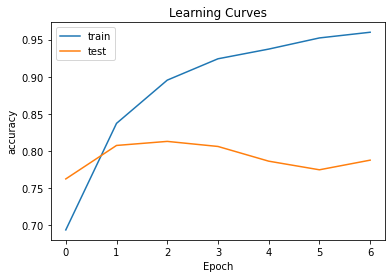

In [19]:
print_results(history, accuracy_curve=True)

## 9. Not working strategies

I tried several other - popular on the Internet (including kaggle) - strategies, but they did not improve the result. Few of them:
TODO: fill in results
- stemming - x AUC, y accuracy
- lemmatization - x AUC, y accuracy
- standard stopwords - x AUC, y accuracy
- single dense 256 units layer after LSTM layers - x AUC, y accuracy
- word2vec trained on this dataset - x AUC, y accuracy
- word2vec trained on bigger dataset (~0.5gb of social media posts) - x AUC, y accuracy

## TODO:
- more tunable params?